In [3]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from datetime import timedelta
from datetime import datetime
import seaborn as sns

from math import log

In [2]:
# ds2 = pd.read_csv("https://abe-southside-final-project.s3.us-east-2.amazonaws.com/athletes.csv",index_col=[0])
# ds2.dtypes
# ds2.head()

In [24]:
# https://www.kaggle.com/pavanraj159/olympics-history-1896-2016/data
olympics = pd.read_csv('athlete_events.csv')
olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


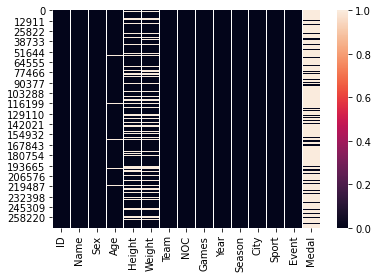

In [25]:
# This data helps us visualize where the null values exist 
sns.heatmap(olympics.isnull())

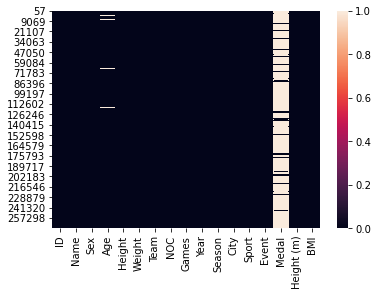

In [26]:
sports = ['Athletics']

olympics = olympics[olympics['Season'] == 'Summer']
olympics = olympics[olympics['Sport'].isin(sports)]
olympics = olympics[olympics['Year']< 2016]
olympics = olympics[olympics['Sex']== 'M']
olympics = olympics[olympics['Height'].notna()]
olympics['Height (m)'] = olympics['Height']/100
olympics = olympics[olympics['Weight'].notna()] 
olympics['BMI'] = round(olympics['Weight']/(olympics['Height (m)']*olympics['Height (m)']),2)
# olympics = olympics[olympics['Medal'] == 'Gold']
# This data helps us visualize where the null values exist 
sns.heatmap(olympics.isnull())

In [27]:
olympics.head()
# olympics['Weight'].max()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Height (m),BMI
57,18,Timo Antero Aaltonen,M,31.0,189.0,130.0,Finland,FIN,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Men's Shot Put,NaN,1.89,36.39
94,31,Evald rma (rman-),M,24.0,174.0,70.0,Estonia,EST,1936 Summer,1936,Summer,Berlin,Athletics,Athletics Men's Pole Vault,NaN,1.74,23.12
98,34,Jamale (Djamel-) Aarrass (Ahrass-),M,30.0,187.0,76.0,France,FRA,2012 Summer,2012,Summer,London,Athletics,"Athletics Men's 1,500 metres",NaN,1.87,21.73
130,47,Erling Rudolf Aastad,M,22.0,177.0,74.0,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Athletics,Athletics Men's 4 x 100 metres Relay,NaN,1.77,23.62
131,47,Erling Rudolf Aastad,M,22.0,177.0,74.0,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Athletics,Athletics Men's Long Jump,NaN,1.77,23.62


Text(0, 0.5, 'Weight')

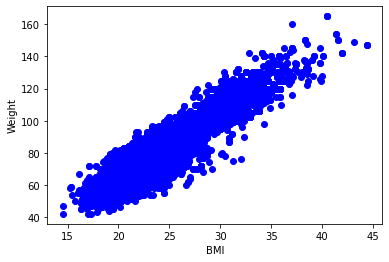

In [53]:
H = olympics['Height (m)']
W = olympics['Weight']
A = olympics['Age']
B = olympics['BMI']
M = olympics['Medal']

plt.scatter(B,W,c="blue")
plt.xlabel("BMI")
plt.ylabel("Weight")

Text(0, 0.5, 'Age')

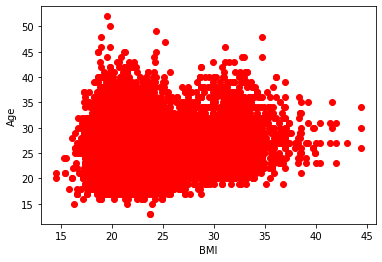

In [55]:
plt.scatter(B,A,c="red")
plt.xlabel("BMI")
plt.ylabel("Age")

In [52]:
plt.scatter(B,W,c="green")
plt.xlabel("BMI")
plt.ylabel("Weight")
plt.legend()

plt.show()

No handles with labels found to put in legend.


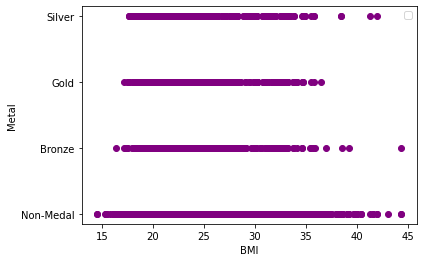

In [58]:
plt.scatter(B,M,c="purple")
plt.xlabel("BMI")
plt.ylabel("Metal")
plt.legend()

plt.show()

In [59]:
# olympics.loc[(olympics['Medal'] == 'Gold'),'Medal']='Medal'
# olympics.loc[(olympics['Medal'] == 'Silver'),'Medal']='Medal'
# olympics.loc[(olympics['Medal'] == 'Bronze'),'Medal']='Medal'
olympics.loc[(olympics['Medal'].isna()),'Medal']= 'Non-Medal'

# wins = ['Gold','Bronze']

# olympics = olympics[olympics['Medal'].isin(wins)]

olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Height (m),BMI
57,18,Timo Antero Aaltonen,M,31.0,189.0,130.0,Finland,FIN,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Men's Shot Put,Non-Medal,1.89,36.39
94,31,Evald rma (rman-),M,24.0,174.0,70.0,Estonia,EST,1936 Summer,1936,Summer,Berlin,Athletics,Athletics Men's Pole Vault,Non-Medal,1.74,23.12
98,34,Jamale (Djamel-) Aarrass (Ahrass-),M,30.0,187.0,76.0,France,FRA,2012 Summer,2012,Summer,London,Athletics,"Athletics Men's 1,500 metres",Non-Medal,1.87,21.73
130,47,Erling Rudolf Aastad,M,22.0,177.0,74.0,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Athletics,Athletics Men's 4 x 100 metres Relay,Non-Medal,1.77,23.62
131,47,Erling Rudolf Aastad,M,22.0,177.0,74.0,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Athletics,Athletics Men's Long Jump,Non-Medal,1.77,23.62


In [31]:
olympics['Medal'].unique()

array(['Non-Medal', 'Bronze', 'Gold', 'Silver'], dtype=object)

(20339, 1) (20339,)


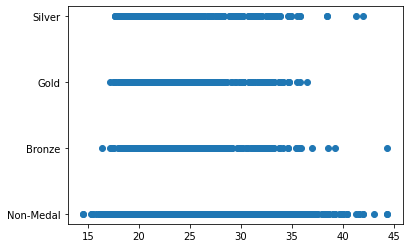

In [41]:
# X = pd.get_dummies(olympics[["Height","Weight"]])
X = olympics[["BMI"]]
y = olympics["Medal"]
print(X.shape, y.shape)

plt.scatter(X,y)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8854726629080897
Testing Data Score: 0.8873156342182891


In [45]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   ['Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal'
 'Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal']
First 10 Actual labels: ['Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Bronze']


In [37]:
Testing = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
Testing

,Prediction,Actual
0,Non-Medal,Non-Medal
1,Non-Medal,Non-Medal
2,Non-Medal,Non-Medal
3,Non-Medal,Non-Medal
4,Non-Medal,Non-Medal
...,...,...
5080,Non-Medal,Non-Medal
5081,Non-Medal,Non-Medal
5082,Non-Medal,Non-Medal
5083,Non-Medal,Non-Medal


In [38]:
# Testing[(Testing['Actual'] != 'Others') & (Testing['Prediction'] != 'Others')]
Testing[(Testing['Prediction'] == 'Medal')]
# Testing[(Testing['Prediction'] == 'Non-Medal')]

,Prediction,Actual


DECISION TREE

In [64]:
X = pd.get_dummies(olympics[["Sex", "Age", "Height", "Weight",'BMI']])
y = olympics["Medal"].values.reshape(-1,1)
print(X.shape, y.shape)
feature_names = X

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

sorted(zip(rf.feature_importances_, feature_names), reverse=True)

(20339, 5) (20339, 1)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Create a random forest classifier
rf = rf.fit(X, y)
rf.score(X, y)

# Random Forests in sklearn will automatically calculate feature importance
importances = rf.feature_importances_
importances

# We can sort the features by their importance
sorted(zip(rf.feature_importances_, X), reverse=True)

NameError: name 'rf' is not defined